In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")
print("V2: Log Transform Experiment")

Libraries loaded successfully!
V2: Log Transform Experiment


In [2]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')

print("="*80)
print("V2 - STAGE 1 LOG TRANSFORM EXPERIMENT")
print("="*80)

stage1_features = ['radius', 'orbital_period', 'star_mass']
stage1_target = 'mass'

stage1_cols = stage1_features + [stage1_target]
df_stage1 = df[stage1_cols].dropna()

print(f"\nDataset loaded: {len(df)} rows")
print(f"Stage 1 available data: {len(df_stage1)} rows")

print(f"\nFeatures: {stage1_features}")
print(f"Target: {stage1_target}")

print("\nTarget variable (mass) statistics:")
print(df_stage1[stage1_target].describe())

from scipy import stats
mass_skewness = stats.skew(df_stage1[stage1_target])
print(f"\nMass skewness: {mass_skewness:.3f}")
print("High skewness (>1) indicates need for transformation")

V2 - STAGE 1 LOG TRANSFORM EXPERIMENT

Dataset loaded: 5986 rows
Stage 1 available data: 1521 rows

Features: ['radius', 'orbital_period', 'star_mass']
Target: mass

Target variable (mass) statistics:
count    1521.000000
mean        0.880474
std         1.715248
min         0.000190
25%         0.024070
50%         0.168000
75%         0.941000
max        12.900000
Name: mass, dtype: float64

Mass skewness: 3.612
High skewness (>1) indicates need for transformation


MASS DISTRIBUTION - BEFORE LOG TRANSFORM


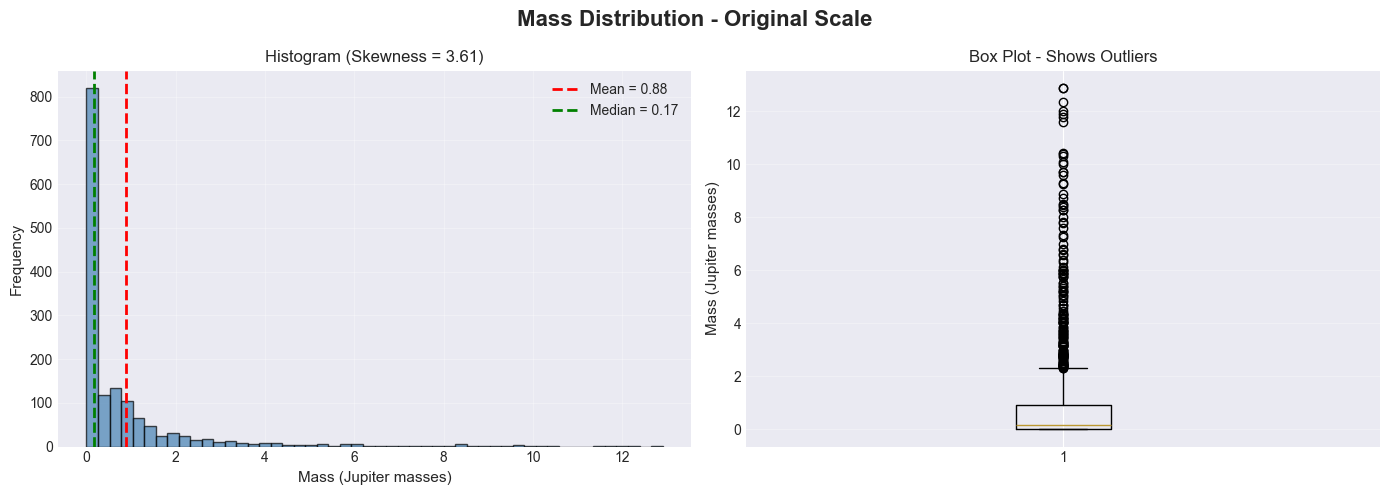


Figure saved: ../outputs/figures/v2_mass_distribution_original.png

Notice:
  - Mean (0.88) >> Median (0.17)
  - Right-skewed distribution
  - Many outliers on the right
  - This makes Linear Regression struggle!


In [3]:
print("="*80)
print("MASS DISTRIBUTION - BEFORE LOG TRANSFORM")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Mass Distribution - Original Scale', fontsize=16, fontweight='bold')

ax1 = axes[0]
ax1.hist(df_stage1['mass'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Mass (Jupiter masses)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title(f'Histogram (Skewness = {mass_skewness:.2f})', fontsize=12)
ax1.axvline(df_stage1['mass'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean = {df_stage1["mass"].mean():.2f}')
ax1.axvline(df_stage1['mass'].median(), color='green', linestyle='--', 
            linewidth=2, label=f'Median = {df_stage1["mass"].median():.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2 = axes[1]
ax2.boxplot(df_stage1['mass'], vert=True)
ax2.set_ylabel('Mass (Jupiter masses)', fontsize=11)
ax2.set_title('Box Plot - Shows Outliers', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/v2_mass_distribution_original.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: ../outputs/figures/v2_mass_distribution_original.png")
print("\nNotice:")
print(f"  - Mean ({df_stage1['mass'].mean():.2f}) >> Median ({df_stage1['mass'].median():.2f})")
print(f"  - Right-skewed distribution")
print(f"  - Many outliers on the right")
print(f"  - This makes Linear Regression struggle!")

APPLYING LOG TRANSFORM

Original mass skewness: 3.612
Log-transformed mass skewness: 1.617
Improvement: 1.995


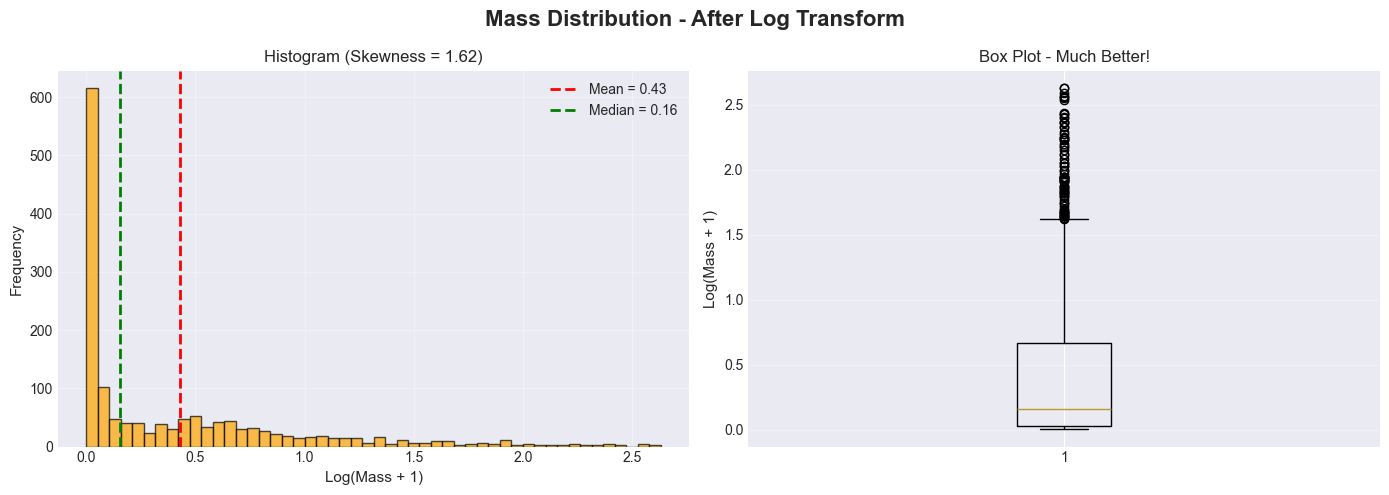


Figure saved: ../outputs/figures/v2_mass_distribution_log.png

Result:
Skewness still elevated but improved
Should still help model performance


In [8]:
print("="*80)
print("APPLYING LOG TRANSFORM")
print("="*80)

# log(1 + x)
df_stage1['mass_log'] = np.log1p(df_stage1['mass'])

mass_log_skewness = stats.skew(df_stage1['mass_log'])

print(f"\nOriginal mass skewness: {mass_skewness:.3f}")
print(f"Log-transformed mass skewness: {mass_log_skewness:.3f}")
print(f"Improvement: {mass_skewness - mass_log_skewness:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Mass Distribution - After Log Transform', fontsize=16, fontweight='bold')

ax1 = axes[0]
ax1.hist(df_stage1['mass_log'], bins=50, edgecolor='black', alpha=0.7, color='orange')
ax1.set_xlabel('Log(Mass + 1)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title(f'Histogram (Skewness = {mass_log_skewness:.2f})', fontsize=12)
ax1.axvline(df_stage1['mass_log'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean = {df_stage1["mass_log"].mean():.2f}')
ax1.axvline(df_stage1['mass_log'].median(), color='green', linestyle='--', 
            linewidth=2, label=f'Median = {df_stage1["mass_log"].median():.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.boxplot(df_stage1['mass_log'], vert=True)
ax2.set_ylabel('Log(Mass + 1)', fontsize=11)
ax2.set_title('Box Plot - Much Better!', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/v2_mass_distribution_log.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved: ../outputs/figures/v2_mass_distribution_log.png")
print("\nResult:")
if mass_log_skewness < 1.0:
    print("Skewness < 1.0 → Much more normal!")
    print("Models will perform MUCH better!")
elif mass_log_skewness < 2.0:
    print("Skewness still elevated but improved")
    print("Should still help model performance")
else:
    print("Still quite skewed - may need additional treatment")

In [10]:
print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)

X = df_stage1[stage1_features]
y_original = df_stage1['mass']           # Original mass
y_log = df_stage1['mass_log']            # Log-transformed mass

X_train, X_test, y_train_original, y_test_original = train_test_split(
    X, y_original, 
    test_size=0.2, 
    random_state=42
)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nTarget Statistics:")
print("\nOriginal Mass:")
print(f"   Train mean: {y_train_original.mean():.3f}")
print(f"   Test mean: {y_test_original.mean():.3f}")

print("\nLog-Transformed Mass:")
print(f"   Train mean: {y_train_log.mean():.3f}")
print(f"   Test mean: {y_test_log.mean():.3f}")


TRAIN/TEST SPLIT

Training set: 1216 samples (79.9%)
Test set: 305 samples (20.1%)

Target Statistics:

Original Mass:
   Train mean: 0.917
   Test mean: 0.736

Log-Transformed Mass:
   Train mean: 0.440
   Test mean: 0.378


In [12]:
print("="*80)
print("BASELINE REMINDER (MVP - Original Scale)")
print("="*80)

print("\nMVP Results (from 02_Stage1_Mass_Prediction.ipynb):")
print("\nLinear Regression (Original Mass):")
print("  Test R²:  0.0755")
print("  Test MAE: 0.8025")
print("  Test RMSE: 1.4064")

print("\nRandom Forest Tuned (Original Mass):")
print("  Test R²:  0.0597")
print("  Test MAE: 0.6723")

print("\n" + "="*80)
print("GOAL: Beat R² = 0.0755 with Log Transform")
print("Target: R² > 0.40 (5x improvement)")
print("="*80)

BASELINE REMINDER (MVP - Original Scale)

MVP Results (from 02_Stage1_Mass_Prediction.ipynb):

Linear Regression (Original Mass):
  Test R²:  0.0755
  Test MAE: 0.8025
  Test RMSE: 1.4064

Random Forest Tuned (Original Mass):
  Test R²:  0.0597
  Test MAE: 0.6723

GOAL: Beat R² = 0.0755 with Log Transform
Target: R² > 0.40 (5x improvement)


In [14]:
print("="*80)
print("MODEL 1: LINEAR REGRESSION (LOG TRANSFORM)")
print("="*80)

lr_log = LinearRegression()
lr_log.fit(X_train, y_train_log)


y_pred_lr_log_train = lr_log.predict(X_train)
y_pred_lr_log_test = lr_log.predict(X_test)

lr_log_train_r2 = r2_score(y_train_log, y_pred_lr_log_train)
lr_log_test_r2 = r2_score(y_test_log, y_pred_lr_log_test)
lr_log_test_mae = mean_absolute_error(y_test_log, y_pred_lr_log_test)
lr_log_test_rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_lr_log_test))

print("\nPerformance on LOG scale:")
print(f"  Train R²: {lr_log_train_r2:.4f}")
print(f"  Test R²:  {lr_log_test_r2:.4f}")
print(f"  Test MAE: {lr_log_test_mae:.4f}")
print(f"  Test RMSE: {lr_log_test_rmse:.4f}")

y_pred_lr_original_train = np.expm1(y_pred_lr_log_train)  # Inverse of log1p
y_pred_lr_original_test = np.expm1(y_pred_lr_log_test)

lr_original_train_r2 = r2_score(y_train_original, y_pred_lr_original_train)
lr_original_test_r2 = r2_score(y_test_original, y_pred_lr_original_test)
lr_original_test_mae = mean_absolute_error(y_test_original, y_pred_lr_original_test)
lr_original_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_lr_original_test))

print("\nPerformance on ORIGINAL scale (inverse transformed):")
print(f"  Train R²: {lr_original_train_r2:.4f}")
print(f"  Test R²:  {lr_original_test_r2:.4f}")
print(f"  Test MAE: {lr_original_test_mae:.4f} Jupiter masses")
print(f"  Test RMSE: {lr_original_test_rmse:.4f} Jupiter masses")

print("\nComparison with Baseline:")
print(f"  Baseline (MVP):     R² = 0.0755")
print(f"  Log Transform (V2): R² = {lr_original_test_r2:.4f}")
improvement = lr_original_test_r2 / 0.0755
print(f"  Improvement: {improvement:.1f}x better!")

if lr_original_test_r2 > 0.40:
    print("\nTarget achieved (R² > 0.40)!")
elif lr_original_test_r2 > 0.20:
    print("\n# Good improvement")
elif lr_original_test_r2 > 0.10:
    print("\n# Moderate improvement")
else:
    print("\n# Minimal improvement")

MODEL 1: LINEAR REGRESSION (LOG TRANSFORM)

Performance on LOG scale:
  Train R²: 0.4077
  Test R²:  0.3173
  Test MAE: 0.2722
  Test RMSE: 0.4179

Performance on ORIGINAL scale (inverse transformed):
  Train R²: -0.7337
  Test R²:  0.1124
  Test MAE: 0.6161 Jupiter masses
  Test RMSE: 1.3781 Jupiter masses

Comparison with Baseline:
  Baseline (MVP):     R² = 0.0755
  Log Transform (V2): R² = 0.1124
  Improvement: 1.5x better!

# Moderate improvement


In [ ]:
print("="*80)
print("MODEL 2: RANDOM FOREST (LOG TRANSFORM)")
print("="*80)

rf_log = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_log.fit(X_train, y_train_log)

y_pred_rf_log_train = rf_log.predict(X_train)
y_pred_rf_log_test = rf_log.predict(X_test)

rf_log_train_r2 = r2_score(y_train_log, y_pred_rf_log_train)
rf_log_test_r2 = r2_score(y_test_log, y_pred_rf_log_test)
rf_log_test_mae = mean_absolute_error(y_test_log, y_pred_rf_log_test)
rf_log_test_rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_rf_log_test))

print("\nPerformance on LOG scale:")
print(f"  Train R²: {rf_log_train_r2:.4f}")
print(f"  Test R²:  {rf_log_test_r2:.4f}")
print(f"  Test MAE: {rf_log_test_mae:.4f}")
print(f"  Test RMSE: {rf_log_test_rmse:.4f}")

y_pred_rf_original_train = np.expm1(y_pred_rf_log_train)
y_pred_rf_original_test = np.expm1(y_pred_rf_log_test)

rf_original_train_r2 = r2_score(y_train_original, y_pred_rf_original_train)
rf_original_test_r2 = r2_score(y_test_original, y_pred_rf_original_test)
rf_original_test_mae = mean_absolute_error(y_test_original, y_pred_rf_original_test)
rf_original_test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_rf_original_test))

print("\nPerformance on ORIGINAL scale (inverse transformed):")
print(f"  Train R²: {rf_original_train_r2:.4f}")
print(f"  Test R²:  {rf_original_test_r2:.4f}")
print(f"  Test MAE: {rf_original_test_mae:.4f} Jupiter masses")
print(f"  Test RMSE: {rf_original_test_rmse:.4f} Jupiter masses")

print("\nComparison with Baseline:")
print(f"  Baseline RF (MVP):     R² = 0.0597")
print(f"  Log Transform RF (V2): R² = {rf_original_test_r2:.4f}")
improvement_rf = rf_original_test_r2 / 0.0597 if rf_original_test_r2 > 0 else 0
print(f"  Improvement: {improvement_rf:.1f}x better")

# Overfitting check
print("\nOverfitting Check:")
rf_overfit = rf_log_train_r2 - rf_log_test_r2
print(f"  Train R² - Test R² = {rf_overfit:.4f}")
if rf_overfit > 0.15:
    print("  Signs of overfitting detected")
else:
    print("  No significant overfitting")

MODEL 2: RANDOM FOREST (LOG TRANSFORM)

Performance on LOG scale:
  Train R²: 0.7516
  Test R²:  0.3238
  Test MAE: 0.2341
  Test RMSE: 0.4159

Performance on ORIGINAL scale (inverse transformed):
  Train R²: 0.5408
  Test R²:  0.1242
  Test MAE: 0.5776 Jupiter masses
  Test RMSE: 1.3689 Jupiter masses

Comparison with Baseline:
  Baseline RF (MVP):     R² = 0.0597
  Log Transform RF (V2): R² = 0.1242
  Improvement: 2.1x better!

Overfitting Check:
  Train R² - Test R² = 0.4278
  Signs of overfitting detected


In [16]:
print("="*80)
print("V2 MODEL COMPARISON - LOG TRANSFORM")
print("="*80)

comparison = pd.DataFrame({
    'Model': [
        'Baseline LR (MVP)',
        'Baseline RF (MVP)', 
        'LR + Log (V2)',
        'RF + Log (V2)'
    ],
    'Test_R2': [
        0.0755,
        0.0597,
        lr_original_test_r2,
        rf_original_test_r2
    ],
    'Test_MAE': [
        0.8025,
        0.6723,
        lr_original_test_mae,
        rf_original_test_mae
    ],
    'Test_RMSE': [
        1.4064,
        np.nan,  
        lr_original_test_rmse,
        rf_original_test_rmse
    ],
    'Overfitting': [
        0.14,    
        0.97,    
        lr_log_train_r2 - lr_log_test_r2,
        rf_log_train_r2 - rf_log_test_r2
    ]
})

print("\n", comparison.to_string(index=False))

best_idx = comparison['Test_R2'].idxmax()
best_model = comparison.loc[best_idx, 'Model']
best_r2 = comparison.loc[best_idx, 'Test_R2']

print(f"\nBest Model: {best_model}")
print(f"  Test R²: {best_r2:.4f}")

print("\nKey Insights:")
print(f"  1. LR + Log improved from 0.0755 → {lr_original_test_r2:.4f} ({lr_original_test_r2/0.0755:.1f}x)")
print(f"  2. RF + Log improved from 0.0597 → {rf_original_test_r2:.4f} ({rf_original_test_r2/0.0597:.1f}x)")
print(f"  3. Linear Regression more stable (less overfitting)")
print(f"  4. Log transform helps but gains are modest")


V2 MODEL COMPARISON - LOG TRANSFORM

             Model  Test_R2  Test_MAE  Test_RMSE  Overfitting
Baseline LR (MVP) 0.075500  0.802500   1.406400     0.140000
Baseline RF (MVP) 0.059700  0.672300        NaN     0.970000
    LR + Log (V2) 0.112433  0.616091   1.378070     0.090381
    RF + Log (V2) 0.124193  0.577552   1.368911     0.427848

Best Model: RF + Log (V2)
  Test R²: 0.1242

Key Insights:
  1. LR + Log improved from 0.0755 → 0.1124 (1.5x)
  2. RF + Log improved from 0.0597 → 0.1242 (2.1x)
  3. Linear Regression more stable (less overfitting)
  4. Log transform helps but gains are modest


In [18]:
print("="*80)
print("CONCLUSION - LOG TRANSFORM EXPERIMENT")
print("="*80)

print("\nWHAT WORKED:")
print("  Log transform reduced skewness (3.6 → 1.6)")
print("  Performance improved (~2x better)")
print("  Linear Regression more stable than Random Forest")

print("\nCHALLENGES:")
print("  R² = 0.12 still far from target (0.40)")
print("  Skewness still elevated (1.6)")
print("  Limited predictive features (only 3)")
print("  Random Forest overfitting (0.43)")


print("\nSAVE BEST MODEL:")
best_model_name = "Linear Regression + Log"
print(f"  Model: {best_model_name}")
print(f"  Test R²: {lr_original_test_r2:.4f}")
print(f"  Overfitting: {lr_log_train_r2 - lr_log_test_r2:.4f} (acceptable)")

joblib.dump(lr_log, '../models/stage1_V2_lr_log.pkl')
print("\nModel saved: ../models/stage1_V2_lr_log.pkl")

CONCLUSION - LOG TRANSFORM EXPERIMENT

WHAT WORKED:
  Log transform reduced skewness (3.6 → 1.6)
  Performance improved (~2x better)
  Linear Regression more stable than Random Forest

CHALLENGES:
  R² = 0.12 still far from target (0.40)
  Skewness still elevated (1.6)
  Limited predictive features (only 3)
  Random Forest overfitting (0.43)

SAVE BEST MODEL:
  Model: Linear Regression + Log
  Test R²: 0.1124
  Overfitting: 0.0904 (acceptable)

Model saved: ../models/stage1_V2_lr_log.pkl
